# One Box Patch Model

Reference: [Sequence Of Boxes](https://docs.google.com/document/d/14vPryt1JFE6Si89VamwMOi-RASeXmMXpo0_BjT_hn-U/edit?usp=sharing)


## Import Necessary Modules

In [150]:
# !pip install -q git+https://github.com/EfficientDL/codelab_utils.git

import pickle
import PIL
import math
import albumentations

import codelab_utils.mpl_styles as mpl_styles
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_model_optimization as tfmot

from tensorflow.keras import layers, optimizers, metrics, losses, utils, initializers
from tensorflow.keras import applications as apps, callbacks as cbs
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from matplotlib import patches as patches
from itertools import accumulate
from functools import reduce

mpl_styles.set_default_styles()
plt.rcParams['font.family'] = 'Poppins'

DEBUG = False

## Dataset Initialization

* We download the 'wider_face' dataset provided by TFDS.

In [50]:
# Load wider_face dataset
train_ds, val_ds, test_ds = tfds.load(
    'wider_face',
    # split=['train[:80%]', 'train[80%:]', 'test'],
    split=['train[:5]', 'validation[:5%]', 'test[:5%]'],
    # split=['train', 'validation', 'test'],
    read_config=tfds.ReadConfig(try_autocache=False)
)

## Box Functions

These functions help to transform the boxes between different formats. Notable formats are:
* Grid Format: It's an NxN grid where each cell contain box specifications such as height and width. Cell coordinates could be box centers (CY, CX) or top-left corner coordinates (Y, X)
* YXYX Format: This format describes a box as a pair of YX coordinates representing top-left and bottom-right corners respectively. The boxes per input are expressed as a list.
* YXHW Format: It describes a box as a pair of top-left coordinates and box height and width. The boxes per input are expressed as a list.
* CYCXHW Format: It describes a box as a pair of center coordinates and box height and width. The boxes per input are expressed as a list.

In [51]:
def make_random_boxes(num_boxes=1):
    """
        It creates random boxes in YXYX format.

        Arguments:
            num_boxes: The number of boxes to create.
        
        Returns:
            A tensor of boxes with shape (num_boxes, 4) with FP values.
            All the values are in range [0., 1.]
    """
    pair_1 = tf.random.uniform((num_boxes, 2))
    pair_2 = tf.random.uniform((num_boxes, 2))

    yx_min = tf.where(pair_1 < pair_2, pair_1, pair_2)
    yx_max = tf.where(pair_1 > pair_2, pair_1, pair_2)

    boxes = tf.concat([yx_min, yx_max], axis=-1)
    return boxes

def make_random_grid_boxes(num_boxes, grid_size):
    """
        Generates a random boxes in a grid.

        Arguments:
            num_boxes: An integer value to indicate the number of boxes to generate.
            grid_size: The size of target grid to fit the boxes into.
        
        Returns:
            A grid containing heights and widths of input boxes fitted based on their top-left coordinates.
            The output shape is (grid_size, grid_size, 2)
    """
    pair_1 = tf.random.uniform((num_boxes, 2))
    pair_2 = tf.random.uniform((num_boxes, 2))

    yx_min = tf.where(pair_1 < pair_2, pair_1, pair_2)
    yx_max = tf.where(pair_1 > pair_2, pair_1, pair_2)

    boxes = tf.concat([yx_min, yx_max], axis=-1)
    box_grid = yxyx_to_hw_grid(boxes, grid_size)

    # box_indices = tf.cast(tf.random.uniform((num_boxes, 2))*grid_size, dtype=tf.int32)
    # box_grid = tf.scatter_nd(indices=box_indices, updates=boxes, shape=(grid_size, grid_size, 4))

    # tf.print('box_indices: ', box_indices, box_indices.shape)
    # tf.print('boxes: ', boxes, boxes.shape)
    # tf.print('box_grid: ', box_grid, box_grid.shape)

    return box_grid

def yx_to_indices(yx, size, dtype=tf.int64):
    return tf.cast(yx*tf.cast((size - 1), dtype=tf.float32), dtype)

def yxyx_to_hw_grid(boxes, grid_size):
    """
        It fits a tensor of flat boxes to a grid of given size.

        Arguments:
            boxes: A tensor of boxes in YXYX format with shape (N_BOXES, 4)
            grid_size: An integer value indicating the size of the target grid.
        
        Returns:
            A grid containing heights and widths of input boxes fitted based on their top-left coordinates.
            The output shape is (grid_size, grid_size, 2)
    """
    yx_min, yx_max = tf.split(boxes, 2, axis=-1)
    hw = yx_max - yx_min

    box_indices = yx_to_indices(yx_min, grid_size, dtype=tf.int32)
    box_grid = tf.scatter_nd(indices=box_indices, updates=hw, shape=(grid_size, grid_size, 2))
    
    return box_grid

def yxkk_to_kk_grid(boxes, grid_size):
    """
        It fits a tensor of flat boxes to a grid of given size.

        Arguments:
            boxes: A tensor of boxes in YXKK format with shape (N_BOXES, 4)
            grid_size: An integer value indicating the size of the target grid.
        
        Returns:
            A grid containing heights and widths of input boxes fitted based on their top-left coordinates.
            The output shape is (grid_size, grid_size, 2)
    """
    yx_min, kk = tf.split(boxes, 2, axis=-1)

    box_indices = yx_to_indices(yx_min, grid_size, dtype=tf.int32)
    box_grid = tf.scatter_nd(indices=box_indices, updates=kk, shape=(grid_size, grid_size, 2))
    
    return box_grid

def hw_grid_to_yxhw(grid):
    """
        It translates a square HW grid to a list of boxes. Only the boxes with non-zero heights
        are qualified.

        Arguments:
            grid: A grid of of shape: (SIZE, SIZE, 2) with HW values in the last dimension.
        
        Returns:
            A tensor of shape (N_BOXES, 4). The last dimension contains YXHW values.
    """
    # Grid size
    size = grid.shape[0]

    # Generate valid box indices. We consider the boxes with non-zero heights as valid boxes
    mask = tf.cast(tf.math.not_equal(grid[:, :, 0], 0.), tf.float32)
    indices = tf.where(mask)

    # Compute YX and HW for valid boxes
    yx = tf.cast(indices/size, dtype=tf.float32)
    hw = tf.gather_nd(indices=indices, params=grid)

    # tf.print('indices: ', indices, indices.shape)
    # tf.print('first grid element', grid[indices[0][0], indices[0][1]])
    # tf.print('last grid element', grid[indices[-1][0], indices[-1][1]])

    yxhw = tf.concat([yx, hw], axis=-1)

    return yxhw

def yxyx_to_cycxhw_grid(boxes, grid_size):
    """
        It converts a tensor of YXYX boxes into a grid of HW values.
        HW values are inserted based on CYCX values into the grid.

        boxes: A tensor of boxes. Shape: (N_BOXES, 4). The last dimension
            contains YXYX values.
        grid_size: The size of the grid to insert HW values.

        Returns:
            A grid with HW values. Shape: (grid_size, grid_size, 2)
    """
    # Compute box CYCX and HW.
    cy, cx = (boxes[:, 0] + boxes[:, 2])/2, (boxes[:, 1] + boxes[:, 3])/2
    cycx, hw = tf.stack([cy, cx], axis=-1), boxes[:, 2:] - boxes[:, :2]

    # Find the grid indices corresponding to the box centers.
    indices = yx_to_indices(cycx, grid_size, dtype=tf.int32)
    
    # tf.print('indices: ', indices, indices.shape)

    # Construct the grid based on the center indices and HW values
    grid = tf.scatter_nd(indices=indices, updates=hw, shape=(grid_size, grid_size, 2))

    # tf.print('grid: ', grid, grid.shape)

    return grid

def yxyx_to_yxhw(boxes):
    """
        It translates the boxes from YXYX format to YXHW format.
        boxes: A tensor of boxes with shape (N_BOXES, 4) in YXYX format.

        Returns:
            A tensor of boxes with shape (N_BOXES, 4) in YXHW format.
    """
    yx_min, yx_max = tf.split(boxes, 2, axis=-1)
    hw = yx_max - yx_min
    hw_boxes = tf.concat([yx_min, hw], axis=-1)
    return hw_boxes

def yxhw_to_yxyx(boxes):
    """
        It translates the boxes from YXHW format to YXYX format.
        boxes: A tensor of boxes with shape (N_BOXES, 4) in YXHW format.

        Returns:
            A tensor of boxes with shape (N_BOXES, 4) in YXYX format.
    """
    yx_min, yx_hw = tf.split(boxes, 2, axis=-1)
    yx_max = tf.clip_by_value(yx_min + yx_hw, 0, 1)
    yxyx_boxes = tf.concat([yx_min, yx_max], axis=-1)
    return yxyx_boxes

def cycxhw_to_yxyx(boxes):
    """
        It translates the boxes from CYCXHW format to YXYX format.
        boxes: A tensor of boxes with shape (N_BOXES, 4) in CYCXHW format.

        Returns:
            A tensor of boxes with shape (N_BOXES, 4) in YXYX format.
    """
    cycx, hw = tf.split(boxes, 2, axis=-1)
    hw_half = hw/2

    yx_min = tf.clip_by_value(cycx - hw_half, 0, 1)
    yx_max = tf.clip_by_value(cycx + hw_half, 0, 1)
    yxyx_boxes = tf.concat([yx_min, yx_max], axis=-1)
    return yxyx_boxes

def yxhw_to_cycxhw(boxes):
    """
        It translates the boxes from CYCXHW format to YXHW format.
        boxes: A tensor of boxes with shape (N_BOXES, 4) in CYCXHW format.

        Returns:
            A tensor of boxes with shape (N_BOXES, 4) in YXHW format.
    """
    yx, hw = tf.split(boxes, 2, axis=-1)
    hw_half = hw/2

    cycx = tf.clip_by_value(yx + hw_half, 0, 1)
    cycxhw_boxes = tf.concat([cycx, hw], axis=-1)
    return cycxhw_boxes

def box_area(boxes):
    """
        It computes the area of the boxes.
        boxes: A tensor of boxes with shape (N_BOXES, 4) in YXYX format.

        Returns:
            A tensor of box areas of shape (N_BOXES, 1)
    """
    y_min, x_min, y_max, x_max = tf.split(boxes, 4, axis=-1)
    return (y_max - y_min)*(x_max - x_min)

# random_boxes = tf.map_fn(lambda v: make_random_grid_boxes(v[0], v[1]), [tf.constant([2, 3]), tf.ones((2))*4], fn_output_signature=tf.float32)

## Patch Functions

In [52]:
def extract_patches(images, boxes, patch_size):
    patch_count = (images.shape[1]//patch_size)**2
    sizes=[1, patch_size, patch_size, 1]
    kwargs = dict(sizes=sizes, strides=sizes, rates=[1, 1, 1, 1], padding='VALID')

    # Extract patches from  images
    image_patches = tf.image.extract_patches(images, **kwargs)
    image_patches = tf.reshape(image_patches, [-1, patch_count, patch_size, patch_size, 3])

    # Extract patches from  boxes
    box_patches = tf.image.extract_patches(boxes, **kwargs)
    box_patches = tf.reshape(box_patches, [-1, patch_count, patch_size, patch_size, 2])


    return image_patches, box_patches

images, boxes = tf.reshape(tf.range(16*256*256*3), (16, 256, 256, 3)), tf.reshape(tf.range(16*256*256*2), (16, 256, 256, 2))
# images, boxes = tf.reshape(tf.range(4*4*3), (1, 4, 4, 3)), tf.reshape(tf.range(4*4*2), (1, 4, 4, 2))
image_patches, box_patches = extract_patches(images, boxes, patch_size=2)

print('Image: {} --> Patches: {}'.format(images.shape, image_patches.shape))
print('Box: {} --> Patches: {}'.format(boxes.shape, box_patches.shape))

tf.print('Image_0: ', images[0])
tf.print('Image_Patch_2: ', image_patches[0, 2])

tf.print('Box_0: ', boxes[0])
tf.print('Box_Patch_2: ', box_patches[0, 2])


Image: (16, 256, 256, 3) --> Patches: (16, 16384, 2, 2, 3)
Box: (16, 256, 256, 2) --> Patches: (16, 16384, 2, 2, 2)
Image_0:  [[[0 1 2]
  [3 4 5]
  [6 7 8]
  ...
  [759 760 761]
  [762 763 764]
  [765 766 767]]

 [[768 769 770]
  [771 772 773]
  [774 775 776]
  ...
  [1527 1528 1529]
  [1530 1531 1532]
  [1533 1534 1535]]

 [[1536 1537 1538]
  [1539 1540 1541]
  [1542 1543 1544]
  ...
  [2295 2296 2297]
  [2298 2299 2300]
  [2301 2302 2303]]

 ...

 [[194304 194305 194306]
  [194307 194308 194309]
  [194310 194311 194312]
  ...
  [195063 195064 195065]
  [195066 195067 195068]
  [195069 195070 195071]]

 [[195072 195073 195074]
  [195075 195076 195077]
  [195078 195079 195080]
  ...
  [195831 195832 195833]
  [195834 195835 195836]
  [195837 195838 195839]]

 [[195840 195841 195842]
  [195843 195844 195845]
  [195846 195847 195848]
  ...
  [196599 196600 196601]
  [196602 196603 196604]
  [196605 196606 196607]]]
Image_Patch_2:  [[[12 13 14]
  [15 16 17]]

 [[780 781 782]
  [783 784 78

## Dataset Preprocessing

Here, we resize the images to a fixed size and filter out the invalid boxes. The boxes are originally expressed as a list in the dataset. We'll transform them to a CYCXHW grid format.

In [53]:
IMG_SIZE = 256
PATCH_SIZE = 16
# PATCH_SIZE = IMG_SIZE//2

def filter_empty_bboxes(item):
    _, bboxes = item['image'], item['faces']['bbox']

    return tf.shape(bboxes)[0] != 0

@tf.function
def preprocess_as_grid(item):
    image, boxes = item['image'], item['faces']['bbox']

    # Resize image to IMG_SIZE
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0

    box_grid = yxyx_to_hw_grid(boxes, IMG_SIZE)

    return image, box_grid

train_prep_ds = train_ds.filter(filter_empty_bboxes).map(preprocess_as_grid, num_parallel_calls=None)
val_prep_ds = val_ds.filter(filter_empty_bboxes).map(preprocess_as_grid, num_parallel_calls=None)
test_prep_ds = test_ds.map(preprocess_as_grid, num_parallel_calls=None)

itr = iter(train_prep_ds)
image, y_true = next(itr)
# image = next(itr)

print('Image: {} HW Box: {}'.format(image.shape, y_true.shape))

# display('image', image)
# display('y_true', y_true), tf.math.reduce_sum(mask, axis=-2)
# itr = iter(train_ds)
# item = next(itr)
# image, boxes = item['image'], item['faces']['bbox']
# image, mask = tf.function(preprocess_as_box_center_mask)(item)
# image, y_true = preprocess_as_center_grid(item)

Image: (256, 256, 3) HW Box: (256, 256, 2)


## Plotting Functions for Images and Boxes

* We plot images and box centers.

Images: (2, 256, 16, 16, 3) Y_True: (2, 256, 16, 16, 2)


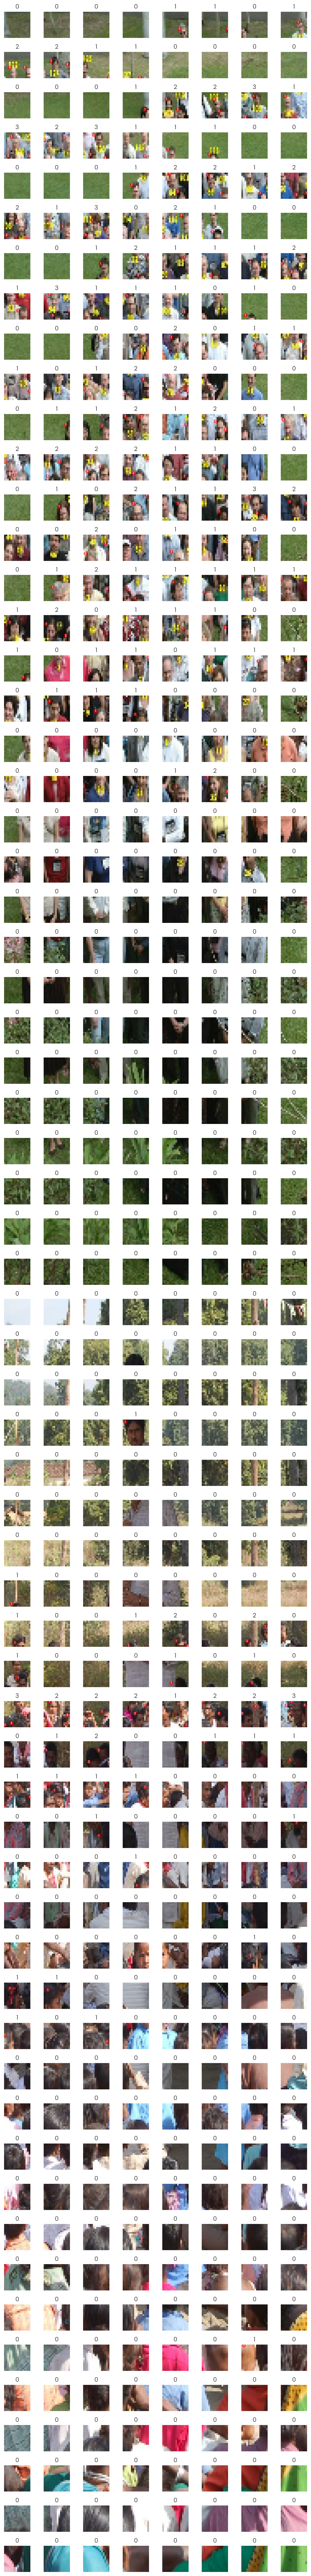

In [54]:
def plot_box_centers(ax, boxes, size, color='green', alpha=1.0, marker_size=None):
    """
        ax: Plot Axes.
        boxes: A tensor of CYCXHW values for the box centers. Shape: (N_BOXES, 4)
        size: Size of the image. It is used to translate the CYCX values to image size.
        color: A string to indicate the color in matplotlib format for the bounding boxes.
        alpha: A FP value for the box fill.
    """
    if boxes is None: return

    boxes = boxes*size
    y, x = boxes[:, 0], boxes[:, 1]

    ax.scatter(x, y, color=color, s=marker_size, alpha=alpha)

    for box_id, yi in enumerate(y):
        xi = x[box_id]
        ax.text(xi, yi, str(box_id + 1), ha='center', va='center', size='xx-small', color='white')

def plot_examples(images, y_true, y_pred, cols=3, match=False, max_pred_boxes=2):
    """
        It plots true and predicted bounding boxes over the images.

        Arguments:
            images: A tensor of images. Shape: (BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3)
            y_true: A grid of box HW values for each feature point. Shape: (BATCH_SIZE, SIZE, SIZE, 2)
            y_pred: A tensor of YXHW values for predicted boxes. Shape: (N_BOXES, 4)
            cols: The number of columns in the plot.
            match: If true, we truncate the predicted boxes to the number of true boxes.
    """
    batch_size = y_pred.shape[0] if y_pred is not None else y_true.shape[0]
    image_size = images.shape[1]

    # Plot configuration
    rows = (batch_size + cols - 1)//cols
    fig, axes = plt.subplots(rows, cols, figsize=(8, 64))
    # fig, axes = plt.subplots(rows, cols, figsize=(8, rows*3))
    color_1, color_2, color_i, color_n = ['red', 'green', 'blue', 'yellow']
    axes = axes.ravel()

    def slice_ys(item_id):
        item_y_true = None if y_true is None else hw_grid_to_yxhw(y_true[item_id])

        # tf.print('item_y_true: ', item_y_true, item_y_true.shape)

        num_y_pred_boxes = tf.shape(item_y_true)[0] if match and item_y_true is not None else max_pred_boxes
        item_y_pred = None if y_pred is None else y_pred[item_id, :num_y_pred_boxes]

        return item_y_true, item_y_pred

    for item_id in range(batch_size):
        # Plot image
        axes[item_id].imshow(images[item_id])
        axes[item_id].set_axis_off()

        item_y_true, item_y_pred = slice_ys(item_id)

        # Plot predicted boxes
        plot_box_centers(axes[item_id], item_y_pred, image_size, color_2, marker_size=20)
        plot_box_centers(axes[item_id], item_y_true, image_size, color_1, alpha=0.5)

        # Add box counts as plot title.
        title = ' | '.join(
            map(
                lambda x: str(int(tf.shape(x)[0])),
                filter(
                    lambda x: x is not None,
                    [item_y_pred, item_y_true]
                )
            )
        )
        axes[item_id].set_title(title)

    plt.tight_layout()

def unpatchify(images, patch_size, y_true=None, y_pred=None):
    images = tf.reshape(images, [-1, patch_size, patch_size, 3])
    y_true = tf.reshape(y_true, [-1, patch_size, patch_size, 2]) if y_true is not None else None
    y_pred = tf.reshape(y_pred, [-1, 1, 4]) if y_pred is not None else None

    return images, y_true, y_pred

itr = iter(train_prep_ds.batch(2).map(lambda x,y: extract_patches(x, y, patch_size=PATCH_SIZE)))
# itr = iter(train_prep_ds.batch(2))
images, y_true = next(itr)

print('Images: {} Y_True: {}'.format(images.shape, y_true.shape))

# y_pred = tf.random.uniform((2, 20, 4))
# plot_examples(images, y_true, y_pred)
# plot_examples(images[0], y_true[0], None)
images, y_true, y_pred = unpatchify(images, PATCH_SIZE, y_true)
plot_examples(images, y_true, y_pred, cols=8)

# r = patches.Rectangle([0, 0], 5, 5)

## Show Training and Validation Examples

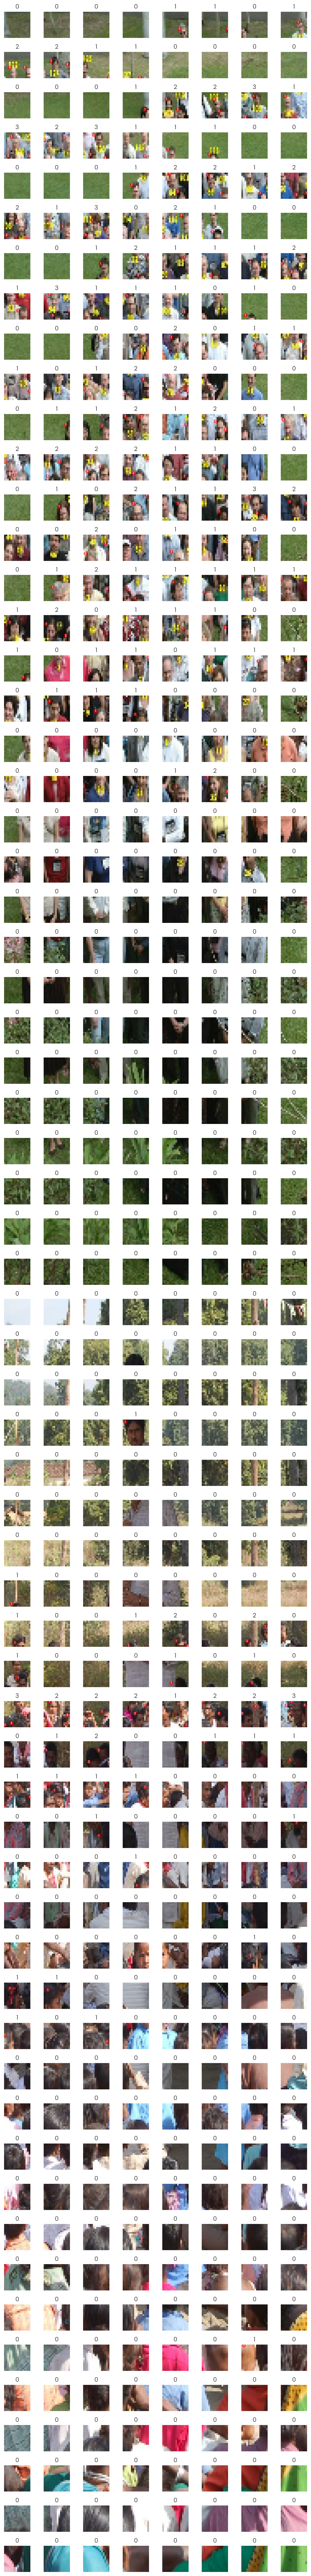

In [55]:
itr = iter(train_prep_ds.batch(2).map(lambda x,y: extract_patches(x, y, patch_size=PATCH_SIZE)))
images, y_true = next(itr)

images, y_true, y_pred = unpatchify(images, PATCH_SIZE, y_true)
plot_examples(images, y_true, y_pred, cols=8)

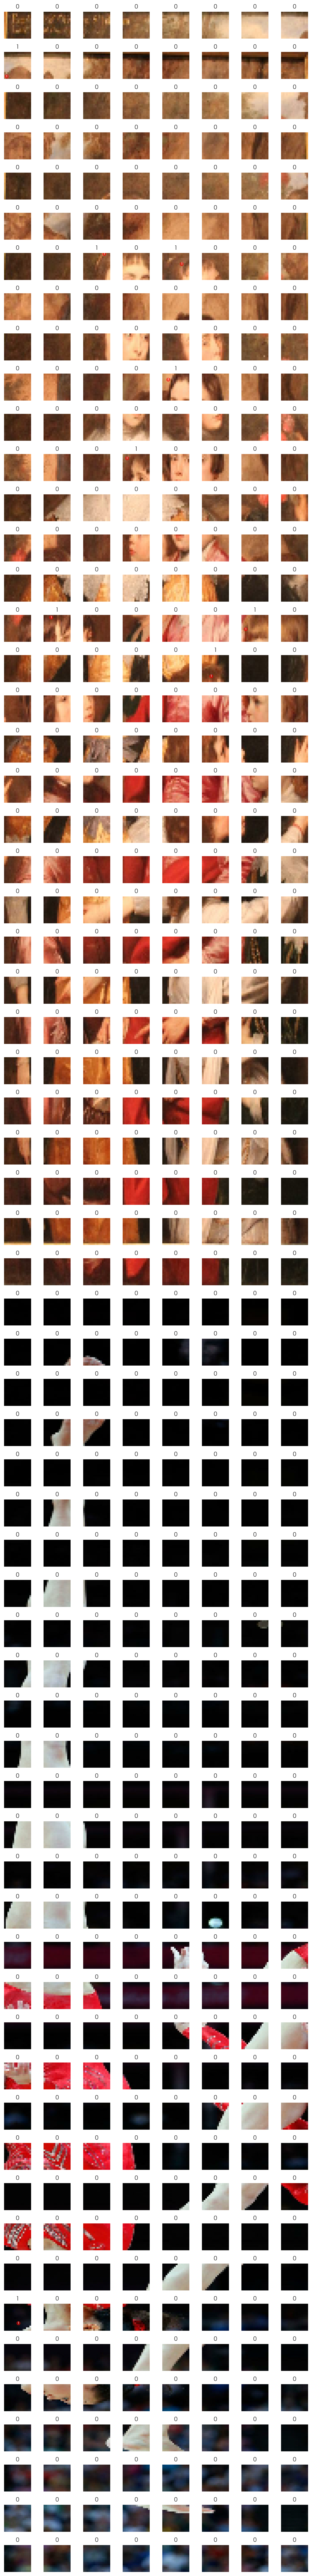

In [56]:
itr = iter(val_prep_ds.batch(2).map(lambda x,y: extract_patches(x, y, patch_size=PATCH_SIZE)))
images, y_true = next(itr)

images, y_true, y_pred = unpatchify(images, PATCH_SIZE, y_true)
plot_examples(images, y_true, y_pred, cols=8)

## ViT Model

### Multilayer Perceptron

In [57]:
def mlp_block(xx, dims, dropout_rate, name='mlp_block'):
    block = tf.keras.Sequential([
        layers.Dense(dims*4, activation='gelu'),
        layers.Dense(dims),
        layers.Dropout(dropout_rate)
    ], name=name)

    return block(xx)

dims, dropout_rate = 8, .2
xx = tf.random.normal((2, 4, 4, 3))
output = mlp_block(xx, dims, dropout_rate)

print('Multilayer Perceptron')
print('dims: {} dropout_rate: {}'.format(dims, dropout_rate))
print('Input: {} --> {}'.format(xx.shape, output.shape))

Multilayer Perceptron
dims: 8 dropout_rate: 0.2
Input: (2, 4, 4, 3) --> (2, 4, 4, 8)


### Embedding Blocks

#### PositionEmbedding Layer

In [193]:
class PositionEmbedding(layers.Layer):
    def __init__(self, initializer="glorot_uniform", **kwargs ):
        super().__init__(**kwargs)
        self._initializer = tf.keras.initializers.get(initializer)

    def get_config(self):
        config = {
            "initializer": tf.keras.initializers.serialize(self._initializer),
        }
        base_config = super(AddEmbedding, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def build(self, input_shape):
        sequence_length = input_shape[-2]
        width = input_shape[-1]

        self._add_embeddings = self.add_weight(
            "add_embeddings",
            shape=[sequence_length, width],
            initializer=self._initializer)

        super().build(input_shape)

    def call(self, inputs):
        return inputs + self._add_embeddings

xx = tf.zeros((2, 4, 12))
l = PositionEmbedding()
output = l(xx)

print('PositionEmbedding Layer')
print('Input: {} --> {}'.format(xx.shape, output.shape))
print(f'Embedding Size: {l.weights[0].shape}')
print(f'Verify Embeddings: {tf.reduce_all(tf.math.equal(output, l.weights))}')

PositionEmbedding Layer
Input: (2, 4, 12) --> (2, 4, 12)
Embedding Size: (4, 12)
Verify Embeddings: True


#### Patch Embedding Block

In [176]:
def patch_embedding_block(xx, dims, name='patch_embedding_block'):
    """
        It embeds the input patches in dims-dimensional space.

        Arguments:
            xx: A tensor with shape:
                (BATCH_SIZE, N_PATCHES, PATCH_SIZE*PATCH_SIZE*N_CHANNELS)
            dims: Latent dimensions in the embedding space.
        
        Returns:
            A tensor with shape:
                (BATCH_SIZE, N_PATCHES, dims)
    """
    block = tf.keras.Sequential([
        layers.Dense(dims)
    ], name=name)

    return block(xx)

dims = 8
xx = tf.random.normal((2, 4, 12))
output = patch_embedding_block(xx, dims)

print('Patch Embedding Block')
print('dims: {}'.format(dims))
print('Input: {} --> {}'.format(xx.shape, output.shape))

Patch Embedding Block
dims: 8
Input: (2, 4, 12) --> (2, 4, 8)


#### Position Embedding Block

In [184]:
def position_embedding_block(xx, dims, name='position_embedding_block'):
    """
        It embeds the input patches in dims-dimensional space.

        Arguments:
            xx: A tensor with shape:
                (BATCH_SIZE, N_PATCHES, PATCH_SIZE*PATCH_SIZE*N_CHANNELS)
            dims: Latent dimensions in the embedding space.
        
        Returns:
            A tensor with shape:
                (BATCH_SIZE, N_PATCHES, dims)
    """
    l = PositionEmbedding()
    x = l(xx)
    # positions = xx.shape[1]
    # embedded_inputs = []
    # for pos in range(positions):
    #     l = layers.Dense(dims)
    #     embedded_input = l(xx[:, pos])
    #     embedded_inputs.append(embedded_input)
    
    # x = tf.stack(embedded_inputs, axis=1)

    block = tf.keras.Model(inputs=xx, outputs=x, name=name)
    # block.summary()

    return block(xx)

dims = 8
xx = tf.keras.Input((4, 12))
# xx = tf.random.normal((2, 4, 12))
output = position_embedding_block(xx, dims)

print('Position Embedding Block')
print('dims: {}'.format(dims))
print('Input: {} --> {}'.format(xx.shape, output.shape))

Position Embedding Block
dims: 8
Input: (None, 4, 12) --> (None, 4, 12)


#### Class Embedding Block

In [149]:
def class_embedding_block(xx, dims, classes, name='class_embedding_block'):
    """
        It embeds the input patches in dims-dimensional space.

        Arguments:
            xx: A tensor with shape:
                (BATCH_SIZE, N_PATCHES, PATCH_SIZE*PATCH_SIZE*N_CHANNELS)
            dims: Latent dimensions in the embedding space.
        
        Returns:
            A tensor with shape:
                (BATCH_SIZE, N_PATCHES, dims)
    """
    positions = xx.shape[1]
    embedded_inputs = []
    for pos in range(positions):
        l = layers.Dense(dims)
        embedded_input = l(xx[:, pos])
        embedded_inputs.append(embedded_input)
    
    x = tf.stack(embedded_inputs, axis=1)

    block = tf.keras.Model(inputs=xx, outputs=x, name=name)
    # block.summary()

    return block(xx)

dims = 8
xx = tf.keras.Input((4, 12))
# xx = tf.random.normal((2, 4, 12))
output = class_embedding_block(xx, dims)

print('Class Embedding Block')
print('dims: {}'.format(dims))
print('Input: {} --> {}'.format(xx.shape, output.shape))

Class Embedding Block
dims: 8
Input: (None, 4, 12) --> (None, 4, 8)


### Encoder Block

In [59]:
def encoder_block(xx, dims, heads, dropout_rate=0.2, name='encoder_block'):

    normalized_1 = layers.Normalization()(xx)
    x = xx + layers.MultiHeadAttention(heads, dims)(normalized_1, normalized_1)
    normalized_2 = layers.Normalization()(x)
    x = x + mlp_block(normalized_2, dims, dropout_rate, name='{}_mlp'.format(name))

    block = tf.keras.Model(inputs=xx, outputs=x, name=name)

    return block(xx)

dims, heads, dropout_rate = 8, 2, .2
# xx = tf.random.normal((2, 4, dims))
xx = tf.keras.Input((4, dims))
output = encoder_block(xx, dims, heads, dropout_rate=dropout_rate)

print('Encoder Block')
print('dims: {}'.format(dims))
print('Input: {} --> {}'.format(xx.shape, output.shape))

Encoder Block
dims: 8
Input: (None, 4, 8) --> (None, 4, 8)


### Decoder Blocks

#### Linear Decoder

In [146]:
def linear_decoder_block(xx, classes, grid_size, name='linear_decoder_block'):
    """
    """
    # Patch level class logits
    x = layers.Dense(classes)(xx)

    # Patch sequence to H/P x W/P grid
    x = layers.Reshape([grid_size, grid_size, classes])(x)
    x = tf.image.resize(x, [IMG_SIZE, IMG_SIZE])
    x = layers.Activation('softmax')(x)

    block = tf.keras.Model(inputs=xx, outputs=x, name=name)

    return block(xx)

sequence_length = 4
classes, grid_size = 4, 2
xx = tf.keras.Input((sequence_length, dims))
output = linear_decoder_block(xx, classes, grid_size)
block = tf.keras.Model(inputs=xx, outputs=output)

xx = tf.random.normal((2, sequence_length, dims))
output = block(xx)

print('Linear Decoder Block')
print('dims: {}'.format(dims))
print('Input: {} --> {}'.format(xx.shape, output.shape))
print(output[0, 0, 0])

Linear Decoder Block
dims: 8
Input: (2, 4, 8) --> (2, 256, 256, 4)
tf.Tensor([0.2641535  0.15952216 0.26010406 0.31622025], shape=(4,), dtype=float32)


#### Mask Transformer Decoder

In [145]:
def transformer_decoder_block(xx, dims, heads, classes, grid_size, dropout_rate=0.2, name='transformer_decoder_block'):
    """
    """
    # Patch level class logits
    x = layers.Dense(classes)(xx)

    # Patch sequence to H/P x W/P grid
    x = layers.Reshape([grid_size, grid_size, classes])(x)
    x = tf.image.resize(x, [IMG_SIZE, IMG_SIZE])
    x = layers.Activation('softmax')(x)
    # normalized_1 = layers.Normalization()(patch_class_logits)
    # x = xx + layers.MultiHeadAttention(heads, dims)(normalized_1, normalized_1)
    # normalized_2 = layers.Normalization()(x)
    # x = x + mlp_block(normalized_2, dims, dropout_rate, name='{}_mlp'.format(name))

    block = tf.keras.Model(inputs=xx, outputs=x, name=name)

    return block(xx)

dims, heads, dropout_rate = 8, 2, .2
sequence_length = 4
classes, grid_size = 4, 2
xx = tf.keras.Input((sequence_length, dims))
output = transformer_decoder_block(xx, dims, heads, classes, grid_size, dropout_rate=dropout_rate)
block = tf.keras.Model(inputs=xx, outputs=output)

xx = tf.random.normal((2, sequence_length, dims))
output = block(xx)

print('Transformer Decoder Block')
print('dims: {}'.format(dims))
print('Input: {} --> {}'.format(xx.shape, output.shape))
print(output[0, 0, 0])

Transformer Decoder Block
dims: 8
Input: (2, 4, 8) --> (2, 256, 256, 4)
tf.Tensor([0.12673739 0.30935705 0.47675234 0.08715326], shape=(4,), dtype=float32)


## Model Assembly

### Projection Head

In [60]:
def projection_head(xx, name='projection_head'):
    block = tf.keras.Sequential([
        layers.Dense(4*4, activation='gelu'),
        layers.Dense(4, activation='sigmoid'),
    ], name=name)

    # Insert additional dimension for the number of predicted boxes.
    x = block(xx)
    x = tf.expand_dims(x, axis=2)

    return x

# xx = tf.random.normal((2, 4, dims))
dims = 8
xx = tf.keras.Input((2, dims))
output = projection_head(xx)

print('Projection Head')
print('Input: {} --> {}'.format(xx.shape, output.shape))

Projection Head
Input: (None, 2, 8) --> (None, 2, 1, 4)


### Architecture

ViT
encoder_units: 2, dims: 8 heads: 2
Input: (None, 2, 16, 16, 3) --> (None, 2, 1, 4)


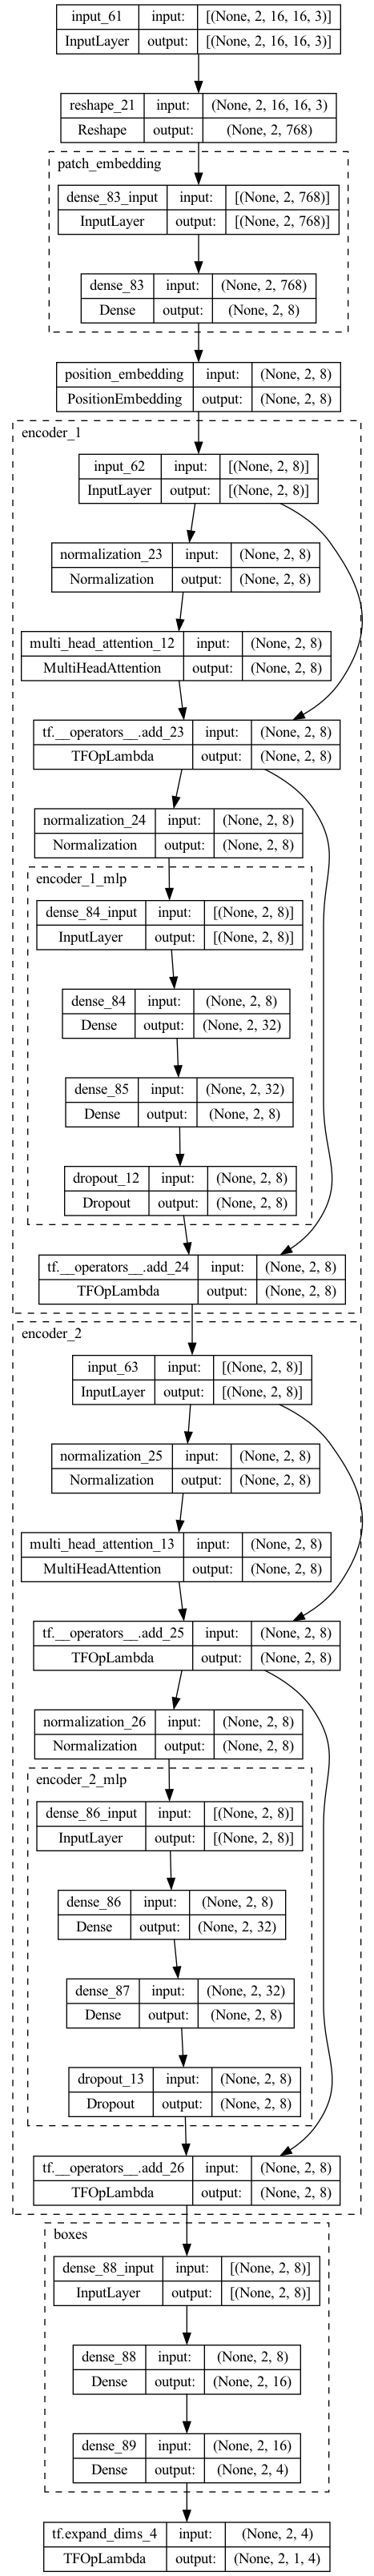

In [192]:
def create_model(num_patches, input_size, encoder_units, dims, heads, dropout_rate=0.2):
    xx = tf.keras.Input((num_patches, input_size, input_size, 3))
    
    x = layers.Reshape([num_patches, -1])(xx)
    x = patch_embedding_block(x, dims, name='patch_embedding')
    x = PositionEmbedding(name='position_embedding')(x)
    # x = position_embedding_block(x, dims, name='position_embedding')
    encoder_fn = lambda x, i: encoder_block(x, dims, heads, name='encoder_{}'.format(i + 1))
    x = reduce(encoder_fn, range(encoder_units), x)
    x = projection_head(x, name='boxes')

    model = tf.keras.Model(inputs=xx, outputs=x, name='PatchTransformer')

    return model

encoder_units, dims, heads = 2, 8, 2
num_patches, input_size = 2, 16
model = create_model(num_patches, input_size, encoder_units, dims, heads)

xx = tf.keras.Input((num_patches, input_size, input_size, 3))
# output = model
output = model(xx)

print('ViT')
print('encoder_units: {}, dims: {} heads: {}'.format(
    encoder_units,
    dims,
    heads
))
print('Input: {} --> {}'.format(xx.shape, output.shape))

utils.plot_model(model, show_shapes=True, expand_nested=True)

## YX Loss Function

In [62]:
LOSS_EPSILON = 1/(IMG_SIZE*IMG_SIZE*IMG_SIZE*IMG_SIZE)

ZERO_FT = 0.
ZERO_INT = 0

def compute_item_yxhw_loss(true_boxes, pred_boxes):
    """
        It computes MAE loss for YX and HW values between true and predicted boxes.
        The losses are computed just for the valid boxes
        Arguments:
            true_boxes: A tensor of boxes with shape (IMG_SIZE, IMG_SIZE, 2)
            The last dimension contains heights and widths of the boxes.

            pred_boxes: A tensor of boxes with shape (N_BOXES, 4)
            The last dimension contains YXHW values.

        Returns:
            * YX Loss
            * HW Loss
            * Box Count
    """
    # Input Grid Size
    size = true_boxes.shape[0]
    max_boxes = pred_boxes.shape[0]

    # tf.print('true_boxes: ', true_boxes, true_boxes.shape)
    # tf.print('pred_boxes: ', pred_boxes, pred_boxes.shape)

    # Generate valid box indices. We consider the boxes with non-zero heights as valid boxes
    boxes_grid_mask = tf.cast(tf.math.not_equal(true_boxes[:, :, 0], 0.), tf.float32)
    boxes_grid_indices = tf.where(boxes_grid_mask)

    # Compute the number of valid boxes and a linear valid box mask.
    num_boxes = tf.shape(boxes_grid_indices)[0]

    # tf.print('boxes_grid_indices: ', boxes_grid_indices, boxes_grid_indices.shape)
    # tf.print('num_boxes: ', num_boxes)
    # tf.print('max_boxes: ', max_boxes)

    if num_boxes == 0:
        return ZERO_FT, ZERO_FT, ZERO_INT

    # Compute YX and HW for valid boxes
    yx_boxes = tf.cast(boxes_grid_indices/size, dtype=tf.float32)
    hw_boxes = tf.gather_nd(indices=boxes_grid_indices, params=true_boxes)

    # tf.print('yx_boxes: ', yx_boxes, tf.shape(yx_boxes))
    # tf.print('hw_boxes: ', hw_boxes, tf.shape(hw_boxes))

    # We'll compute YX and HW losses individually.
    # We split the pred_boxes into YX and HW.
    yx_pred, hw_pred = tf.split(pred_boxes, 2, axis=-1)

    # tf.print('yx_pred: ', yx_pred, tf.shape(yx_pred))
    # tf.print('hw_pred: ', hw_pred, tf.shape(hw_pred))

    # Compute HW loss
    # yx_loss = tf.math.square(yx_pred[:num_boxes] - yx_boxes)
    # hw_loss = tf.math.abs(tf.math.log((hw_pred[:num_boxes] + LOSS_EPSILON)/(hw_boxes + LOSS_EPSILON)))
    yx_loss = tf.math.square(yx_pred - yx_boxes[:max_boxes])
    hw_loss = tf.math.abs(tf.math.log((hw_pred + LOSS_EPSILON)/(hw_boxes[:max_boxes] + LOSS_EPSILON)))

    # tf.print('yx_loss: ', yx_loss, tf.shape(yx_loss))
    # tf.print('hw_loss: ', hw_loss, tf.shape(hw_loss))

    return tf.math.reduce_sum(yx_loss), tf.math.reduce_sum(hw_loss), num_boxes

def compute_patch_yxhw_loss(y_true, y_pred):
    yx_loss, hw_loss, num_boxes = 0., 0., 0
    y_true_shape = tf.shape(y_true)
    batch_size, num_patches = y_true_shape[0], y_true_shape[1]

    for item_id in range(batch_size):
        for patch_id in range(num_patches):
            # item_id = 0
            result  = compute_item_yxhw_loss(y_true[item_id, patch_id], y_pred[item_id, patch_id])
            item_yx_loss, item_hw_loss, item_num_boxes = result

            yx_loss += item_yx_loss
            hw_loss += item_hw_loss
            num_boxes += item_num_boxes

            # tf.print('item_hw_loss:{}: '.format(item_id), item_hw_loss)
            # tf.print('item_num_boxes:{}: '.format(item_id), item_num_boxes)

    # tf.print('num_boxes: ', num_boxes)
    # tf.print('yx_loss: ', yx_loss)
    # tf.print('hw_loss: ', hw_loss)
    
    yx_loss = tf.math.divide_no_nan(yx_loss, tf.cast(num_boxes, dtype=tf.float32))
    hw_loss = tf.math.divide_no_nan(hw_loss, tf.cast(num_boxes, dtype=tf.float32))

    # tf.print('loss: ', loss)

    return yx_loss, hw_loss


compute_patch_yxhw_loss.__name__ = 'loss'

@tf.function
def make_random_grid_boxes_tfn(args):
    return make_random_grid_boxes(args[0], args[1])

y_true = tf.map_fn(make_random_grid_boxes_tfn, [tf.constant([2, 3]), tf.constant([4, 4])], fn_output_signature=tf.float32)
y_true = tf.expand_dims(y_true, axis=1)
y_pred = tf.random.uniform((2, 1, 1, 4))

yx_loss, hw_loss = compute_patch_yxhw_loss(y_true, y_pred)
print('y_true: {} y_pred: {}'.format(y_true.shape.as_list(), y_pred.shape.as_list()))
print('yx_loss: {:.5f} hw_loss: {:.5f}'.format(yx_loss.numpy(), hw_loss.numpy()))

2023-05-24 10:59:07.084900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


y_true: [2, 1, 4, 4, 2] y_pred: [2, 1, 1, 4]
yx_loss: 0.39003 hw_loss: 2.42844


## History and Metrics Functions

In [63]:
class Mean(metrics.Metric):
    def __init__(self, name="mean", **kwargs):
        super(Mean, self).__init__(name=name, **kwargs)
        self.total = self.add_weight(name='total_{}'.format(name), initializer="zeros")
        self.count = self.add_weight(name='count_{}'.format(name), initializer="zeros")

    def update_state(self, result):
        self.total.assign_add(result)
        self.count.assign_add(1)

    def result(self):
        return tf.math.divide_no_nan(self.total, self.count)

    def reset_state(self):
        # The state of the metric will be reset at the start of each epoch.
        self.total.assign(0.0)
        self.count.assign(0)

class History(object):
    def __init__(self):
        self.metrics = dict(
            learning_rate = Mean(name='learning_rate'),

            # loss = Mean(name='loss'),
            # val_loss = Mean(name='val_loss'),

            yx_loss = Mean(name='yx_loss'),
            val_yx_loss = Mean(name='val_yx_loss'),

            # hw_loss = Mean(name='hw_loss'),
            # val_hw_loss = Mean(name='val_hw_loss'),

            # iou = Mean(name='iou'),
            # val_iou = Mean(name='val_iou'),

            # positive_iou = Mean(name='positive_iou'),
            # val_positive_iou = Mean(name='val_positive_iou'),

            # negative_iou = Mean(name='negative_iou'),
            # val_negative_iou = Mean(name='val_negative_iou'),
        )
        self.history = {name: [] for name, metric in self.metrics.items()}
    
    @property
    def metric_names(self):
        return list(self.metrics.keys())

    @property
    def training_metrics_names(self):
        return list(filter(lambda name: not name.startswith('val_'), self.metrics.keys()))
    
    @property
    def training_metrics(self):
        return [(name, self.metrics[name].result()) for name in self.training_metrics_names]

    @property
    def metric_values(self):
        return [(name, metric.result()) for name, metric in self.metrics.items()]
    
    def train_step(self, yx_loss):
    # def train_step(self, yx_loss, hw_loss, iou, positive_iou, negative_iou):
        # self.metrics['loss'].update_state(yx_loss + hw_loss)
        self.metrics['yx_loss'].update_state(yx_loss)
        # self.metrics['hw_loss'].update_state(hw_loss)

        # self.metrics['iou'].update_state(iou)
        # self.metrics['positive_iou'].update_state(positive_iou)
        # self.metrics['negative_iou'].update_state(negative_iou)

        return self.training_metrics
    
    def val_step(self, yx_loss):
    # def val_step(self, yx_loss, hw_loss, iou, positive_iou, negative_iou):
        # self.metrics['val_loss'].update_state(yx_loss + hw_loss)
        self.metrics['val_yx_loss'].update_state(yx_loss)
        # self.metrics['val_hw_loss'].update_state(hw_loss)

        # self.metrics['val_iou'].update_state(iou)
        # self.metrics['val_positive_iou'].update_state(positive_iou)
        # self.metrics['val_negative_iou'].update_state(negative_iou)

        return self.metric_values
    
    def learning_rate(self, lr_value):
        self.metrics['learning_rate'].update_state(lr_value)
    
    def epoch(self):
        # Record the current epoch values before reset.
        values = self.metric_values

        for name in self.metrics.keys():
            self.record_and_reset(name)
        
        return values
    
    def record_and_reset(self, name):
        self.history[name].append(self.metrics[name].result().numpy())
        self.metrics[name].reset_state()

## Optimizer Functions

In [66]:

def get_optimizer(learning_rate=0.001):
    optimizer = optimizers.Adam(learning_rate=learning_rate)

    return optimizer

o = get_optimizer()
print('Learning Rate: {:5f}'.format(o.learning_rate.numpy()))

Learning Rate: 0.001000


## Training Functions

In [68]:
@tf.function
def train_step(model, optimizer, x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)

        # y = tf.reshape(y, (-1, ) + tuple(y.shape[2:]))
        # logits = tf.reshape(logits, (-1, ) + tuple(logits.shape[2:]))

        yx_loss, hw_loss = compute_patch_yxhw_loss(y, logits)
        loss = yx_loss + hw_loss
        # iou, positive_iou, negative_iou = compute_iou_metric(y, logits)

    # Compute gradients and backpropagate.
    grads = tape.gradient(yx_loss, model.trainable_weights)
    # grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # # return yx_loss, hw_loss, iou, positive_iou, negative_iou
    return yx_loss

@tf.function
def val_step(model, x, y):
    logits = model(x, training=False)

    # y = tf.reshape(y, (-1, ) + tuple(y.shape[2:]))
    # logits = tf.reshape(logits, (-1, ) + tuple(logits.shape[2:]))

    yx_loss, hw_loss = compute_patch_yxhw_loss(y, logits)
    # iou, positive_iou, negative_iou = compute_iou_metric(y, logits)
    
    # return yx_loss, hw_loss, iou, positive_iou, negative_iou
    return yx_loss

def train(model, optimizer, tds, vds, steps=20, epochs=100):
    # Record progress
    ckpt = tf.train.Checkpoint(model=model, optimizer=optimizer)
    ckpt_manager = tf.train.CheckpointManager(ckpt, './one_box_patch', max_to_keep=3)
    history = History()
    
    tds = tds.prefetch(buffer_size=tf.data.AUTOTUNE)
    vds = vds.prefetch(buffer_size=tf.data.AUTOTUNE) if vds else []

    history.learning_rate(optimizer.learning_rate)
    history.record_and_reset('learning_rate')

    for epoch in range(epochs):
        # Track training progress
        print("\nEpoch {}/{}".format(epoch + 1, epochs))
        p_bar = utils.Progbar(steps, stateful_metrics=history.metric_names)
        steps = 0

        for step, (x, y) in enumerate(iter(tds)):
            # yx_loss, hw_loss, iou, positive_iou, negative_iou = train_step(model, optimizer, x, y)
            # p_bar.update(step + 1, values=history.train_step(yx_loss, hw_loss, iou, positive_iou, negative_iou))
            
            yx_loss = train_step(model, optimizer, x, y)
            p_bar.update(step + 1, values=history.train_step(yx_loss))
            steps += 1
        
        # Record learning rates
        # history.learning_rate(optimizer.lr((epoch + 1)*steps))
        history.learning_rate(optimizer.learning_rate)
        
        for x, y in iter(vds):
            # yx_loss, hw_loss, iou, positive_iou, negative_iou = val_step(model, x, y)
            # history.val_step(yx_loss, hw_loss, iou, positive_iou, negative_iou)

            yx_loss = val_step(model, x, y)
            history.val_step(yx_loss)
        
        # Display metrics at the end of each epoch.
        p_bar.update(steps, values=history.epoch())

        # Save Checkpoint
        print('\nSaved Checkpoint: {}'.format(ckpt_manager.save()))


    return history

def create_random_dataset(items, num_patches, input_size):
    xt = tf.random.uniform((items, num_patches, input_size, input_size, 3))
    yt = []
    
    for item_id in range(items):
        yt.append(list(map(lambda ix: make_random_grid_boxes(2, input_size), range(num_patches))))
    
    return xt, yt

# num_patches, input_size, encoder_units, dims, heads = 1, 16, 2, 8, 2
# model = create_model(num_patches, input_size, encoder_units, dims, heads)
# optimizer = get_optimizer()

# xt, yt = create_random_dataset(2, num_patches, input_size)
# tds = tf.data.Dataset.from_tensor_slices((xt, yt)).batch(2)

# itr = iter(tds)
# xs, ys = next(itr)
# print('X: {} Y: {}'.format(xs.shape.as_list(), ys.shape.as_list()))

# # train_step(model, optimizer, xs, ys)

# optimizer = get_optimizer()
# hist = train(model, optimizer, tds, tds, steps=2, epochs=2)
# hist.history

X: [2, 1, 16, 16, 3] Y: [2, 1, 16, 16, 2]

Epoch 1/2


2023-05-23 16:08:52.700045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 2s - learning_rate: 0.0000e+00 - yx_loss: 0.0000e+00

2023-05-23 16:08:54.028613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 2s - learning_rate: 0.0010 - yx_loss: 0.0000e+00 - val_yx_loss: 0.0000e+00
Saved Checkpoint: ./one_box_patch/ckpt-1

Epoch 2/2
1/1 [==============================] - 0s 58ms/step - learning_rate: 0.0010 - yx_loss: 0.0000e+00 - val_yx_loss: 0.0000e+00

Saved Checkpoint: ./one_box_patch/ckpt-2


{'learning_rate': [0.001, 0.001, 0.001],
 'yx_loss': [0.0, 0.0],
 'val_yx_loss': [0.0, 0.0]}

## Model Training

### Hyperparameters

In [41]:
INPUT_SIZE = PATCH_SIZE
NUM_PATCHES = (IMG_SIZE//PATCH_SIZE)**2

ENCODER_UNITS, DIMS, HEADS = 2, 64, 3
STEPS, EPOCHS, BATCH_SIZE = 2, 2, 2

### Initialize Model and Optimizer

In [42]:
model = create_model(NUM_PATCHES, INPUT_SIZE, ENCODER_UNITS, DIMS, HEADS)
optimizer = get_optimizer()

### Training Loop

In [49]:
def patch_map_fn(x, y):
    return extract_patches(x, y, PATCH_SIZE)

tds = train_prep_ds.shuffle(500, reshuffle_each_iteration=True).batch(BATCH_SIZE).map(patch_map_fn)
vds = val_prep_ds.batch(32).map(patch_map_fn).cache()

hist = train(model, optimizer, tds, vds, steps=STEPS, epochs=EPOCHS)

with open('training.results.pkl', 'wb') as f:
    pickle.dump(hist.history, f)


Epoch 1/2


2023-05-23 15:16:55.565768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 78s 26s/step - learning_rate: 0.0000e+00 - yx_loss: 0.2708


2023-05-23 15:18:13.429487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/2 [=============================================] - 104s 26s/step - learning_rate: 0.0000e+00 - yx_loss: 0.2502


2023-05-23 15:18:39.378245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


: 

: 

### Metrics

{'learning_rate': [0.001, 0.001, 0.001],
 'yx_loss': [0.0, 0.0],
 'val_yx_loss': [0.0, 0.0]}

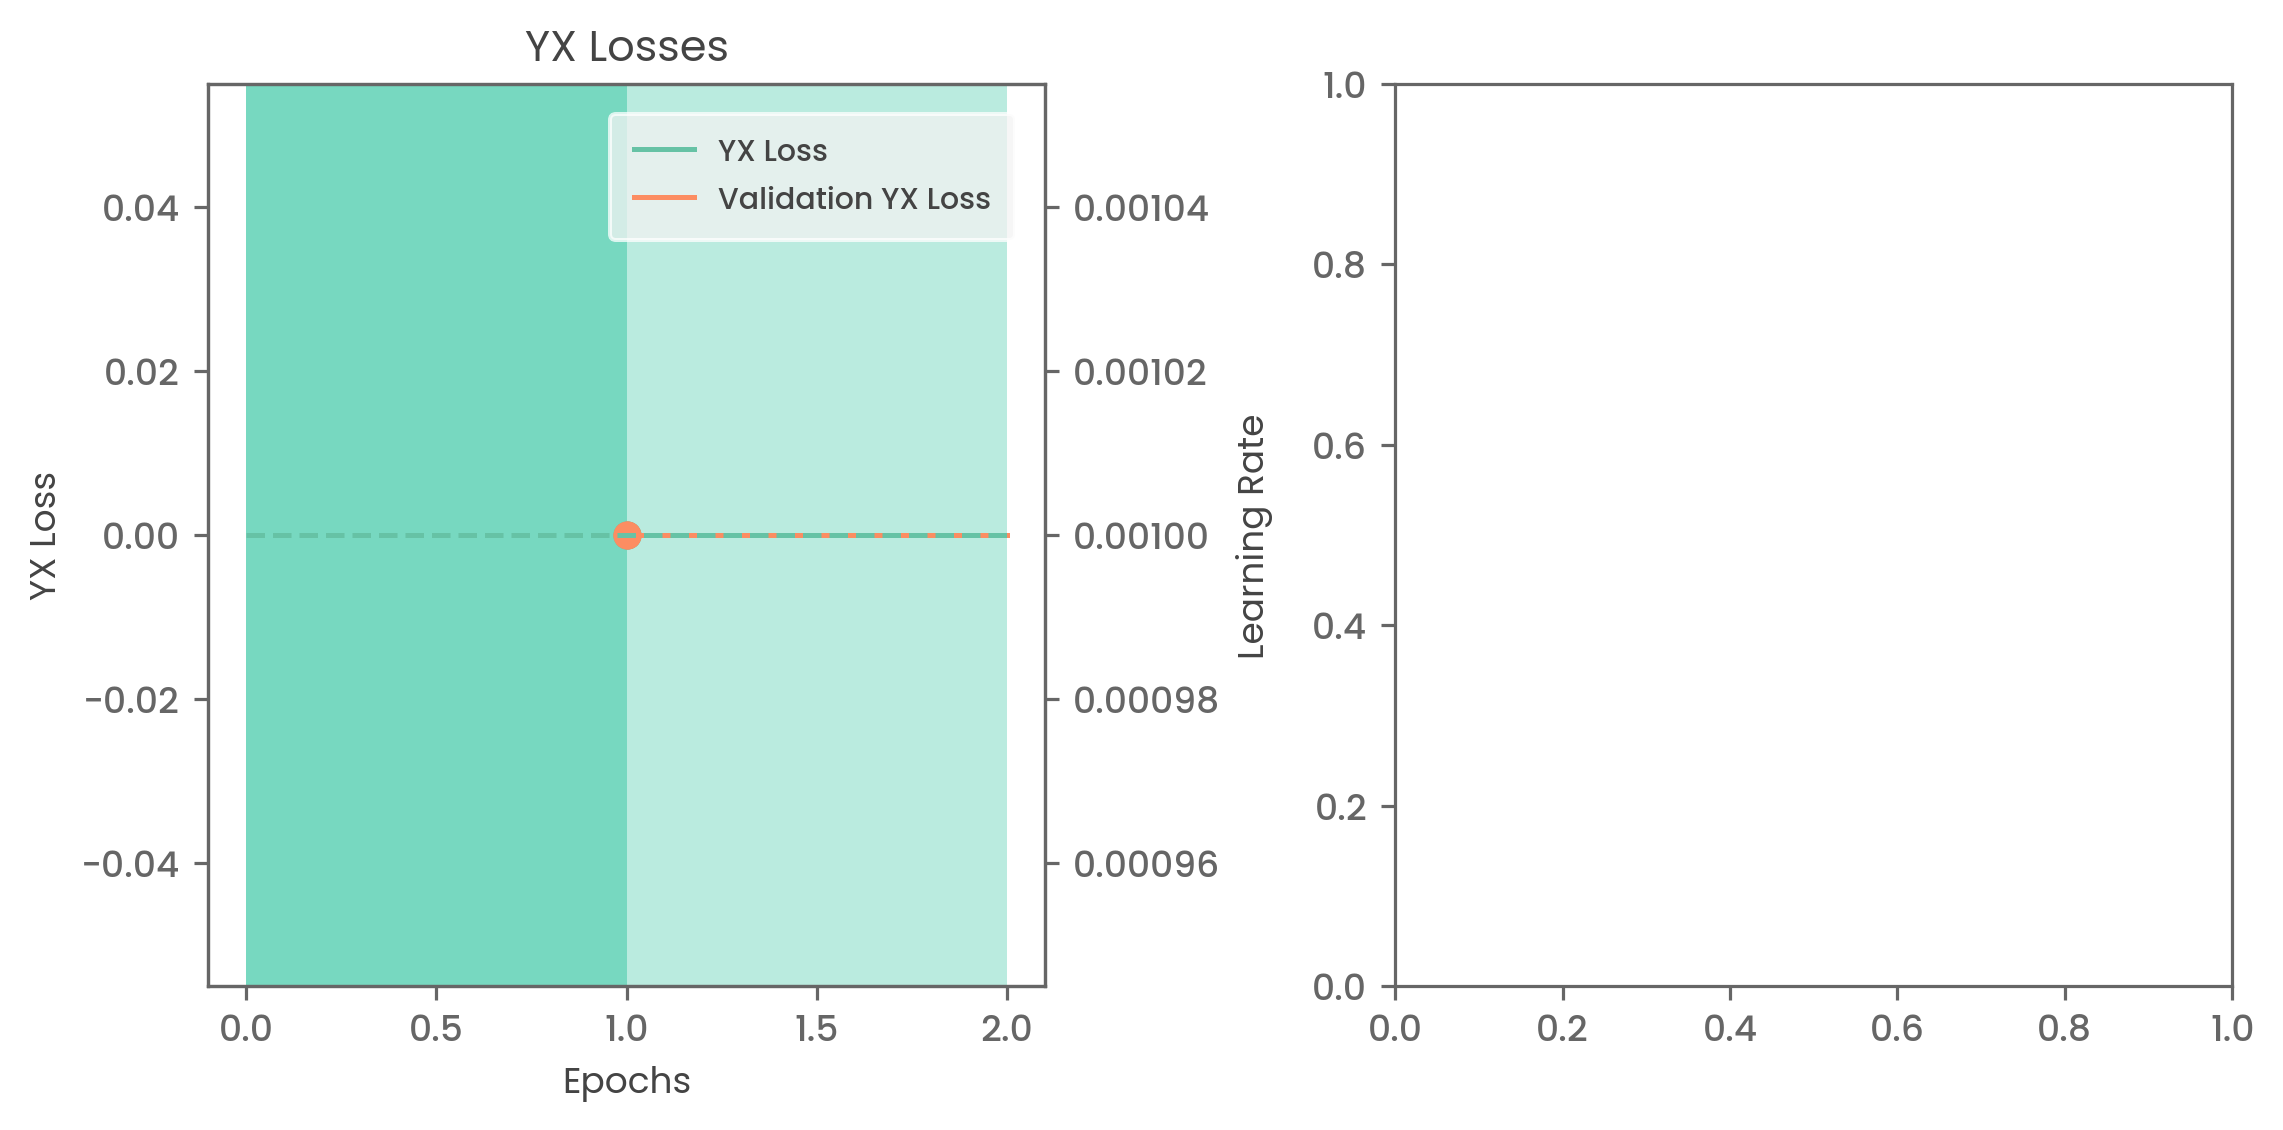

In [ ]:
def mark_max_min(ax, column):
    xs = [column.idxmin(), column.idxmax()]
    ys = [column.min(), column.max()]
    
    ax.scatter(xs, ys, zorder=2)

def plot_metrics(ax, df, name, title=None):
    # Plot training metrics
    sns.lineplot(ax=ax, x='Epochs', y=name, data=df, label=name)
    mark_max_min(ax, df[name])

    # Plot validation metrics
    val_name = 'Validation {}'.format(name)
    sns.lineplot(ax=ax, x='Epochs', y=val_name, data=df, label=val_name)
    mark_max_min(ax, df[val_name])

    # Plot learning rates on the right Y-axis
    lr_ax = ax.twinx()
    sns.lineplot(ax=lr_ax, x='Epochs', y='Learning Rate', data=df, linestyle='--')

    for index, lr_value in enumerate(df['Learning Rate'][:-1]):
        ax.axvspan(index, index + 1, fc='#77d8c0', alpha=(1 - (1/(len(df) - 1))*(index)))

    # Label the plots
    ax.legend()
    ax.set_title(title if title else name)

def load_history_as_df(h):
    epochs = len(h['yx_loss'])
    data = list(zip(
        h['yx_loss'],
        h['val_yx_loss'],

        # h['hw_loss'],
        # h['val_hw_loss'],

        # h['loss'],
        # h['val_loss'],

        # h['positive_iou'],
        # h['val_positive_iou'],

        # h['negative_iou'],
        # h['val_negative_iou'],

        # h['iou'],
        # h['val_iou'],

        h['learning_rate'][1:]
    ))

    df = pd.DataFrame(data, columns=[
        'YX Loss',
        'Validation YX Loss',

        # 'HW Loss',
        # 'Validation HW Loss',

        # 'Loss',
        # 'Validation Loss',

        # 'Positive IoU',
        # 'Validation Positive IoU',

        # 'Negative IoU',
        # 'Validation Negative IoU',

        # 'IoU',
        # 'Validation IoU',

        'Learning Rate'
    ], index=range(1, epochs + 1))

    df.at[0, 'Learning Rate'] = h['learning_rate'][0]
    df = df.sort_index()
    df['Epochs'] = df.index

    return df

def plot_history(h):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), facecolor='w', edgecolor='k')
    # fig, axes = plt.subplots(3, 2, figsize=(12, 12), facecolor='w', edgecolor='k')
    axes = axes.ravel()

    # yx_loss, hw_loss, loss, positive_iou, negative_iou, iou = axes
    yx_loss, _ = axes

    df = load_history_as_df(h)

    # Plot loss metrics
    plot_metrics(yx_loss, df, 'YX Loss', title='YX Losses')
    # plot_metrics(hw_loss, df, 'HW Loss', title='HW Losses')
    # plot_metrics(loss, df, 'Loss', title='Losses')

    # # Plot positive IoU metrics
    # plot_metrics(positive_iou, df, 'Positive IoU', title='Positive IoUs')

    # # Plot positive IoU metrics
    # plot_metrics(negative_iou, df, 'Negative IoU', title='Negative IoUs')

    # # Plot IoU metrics
    # plot_metrics(iou, df, 'IoU', title='IoUs')

    plt.tight_layout()

plot_history(hist.history)
hist.history

## Evaluation

### Evaluation on Training Data

Images: (2, 4, 128, 128, 3) Y_True: (2, 4, 128, 128, 2)


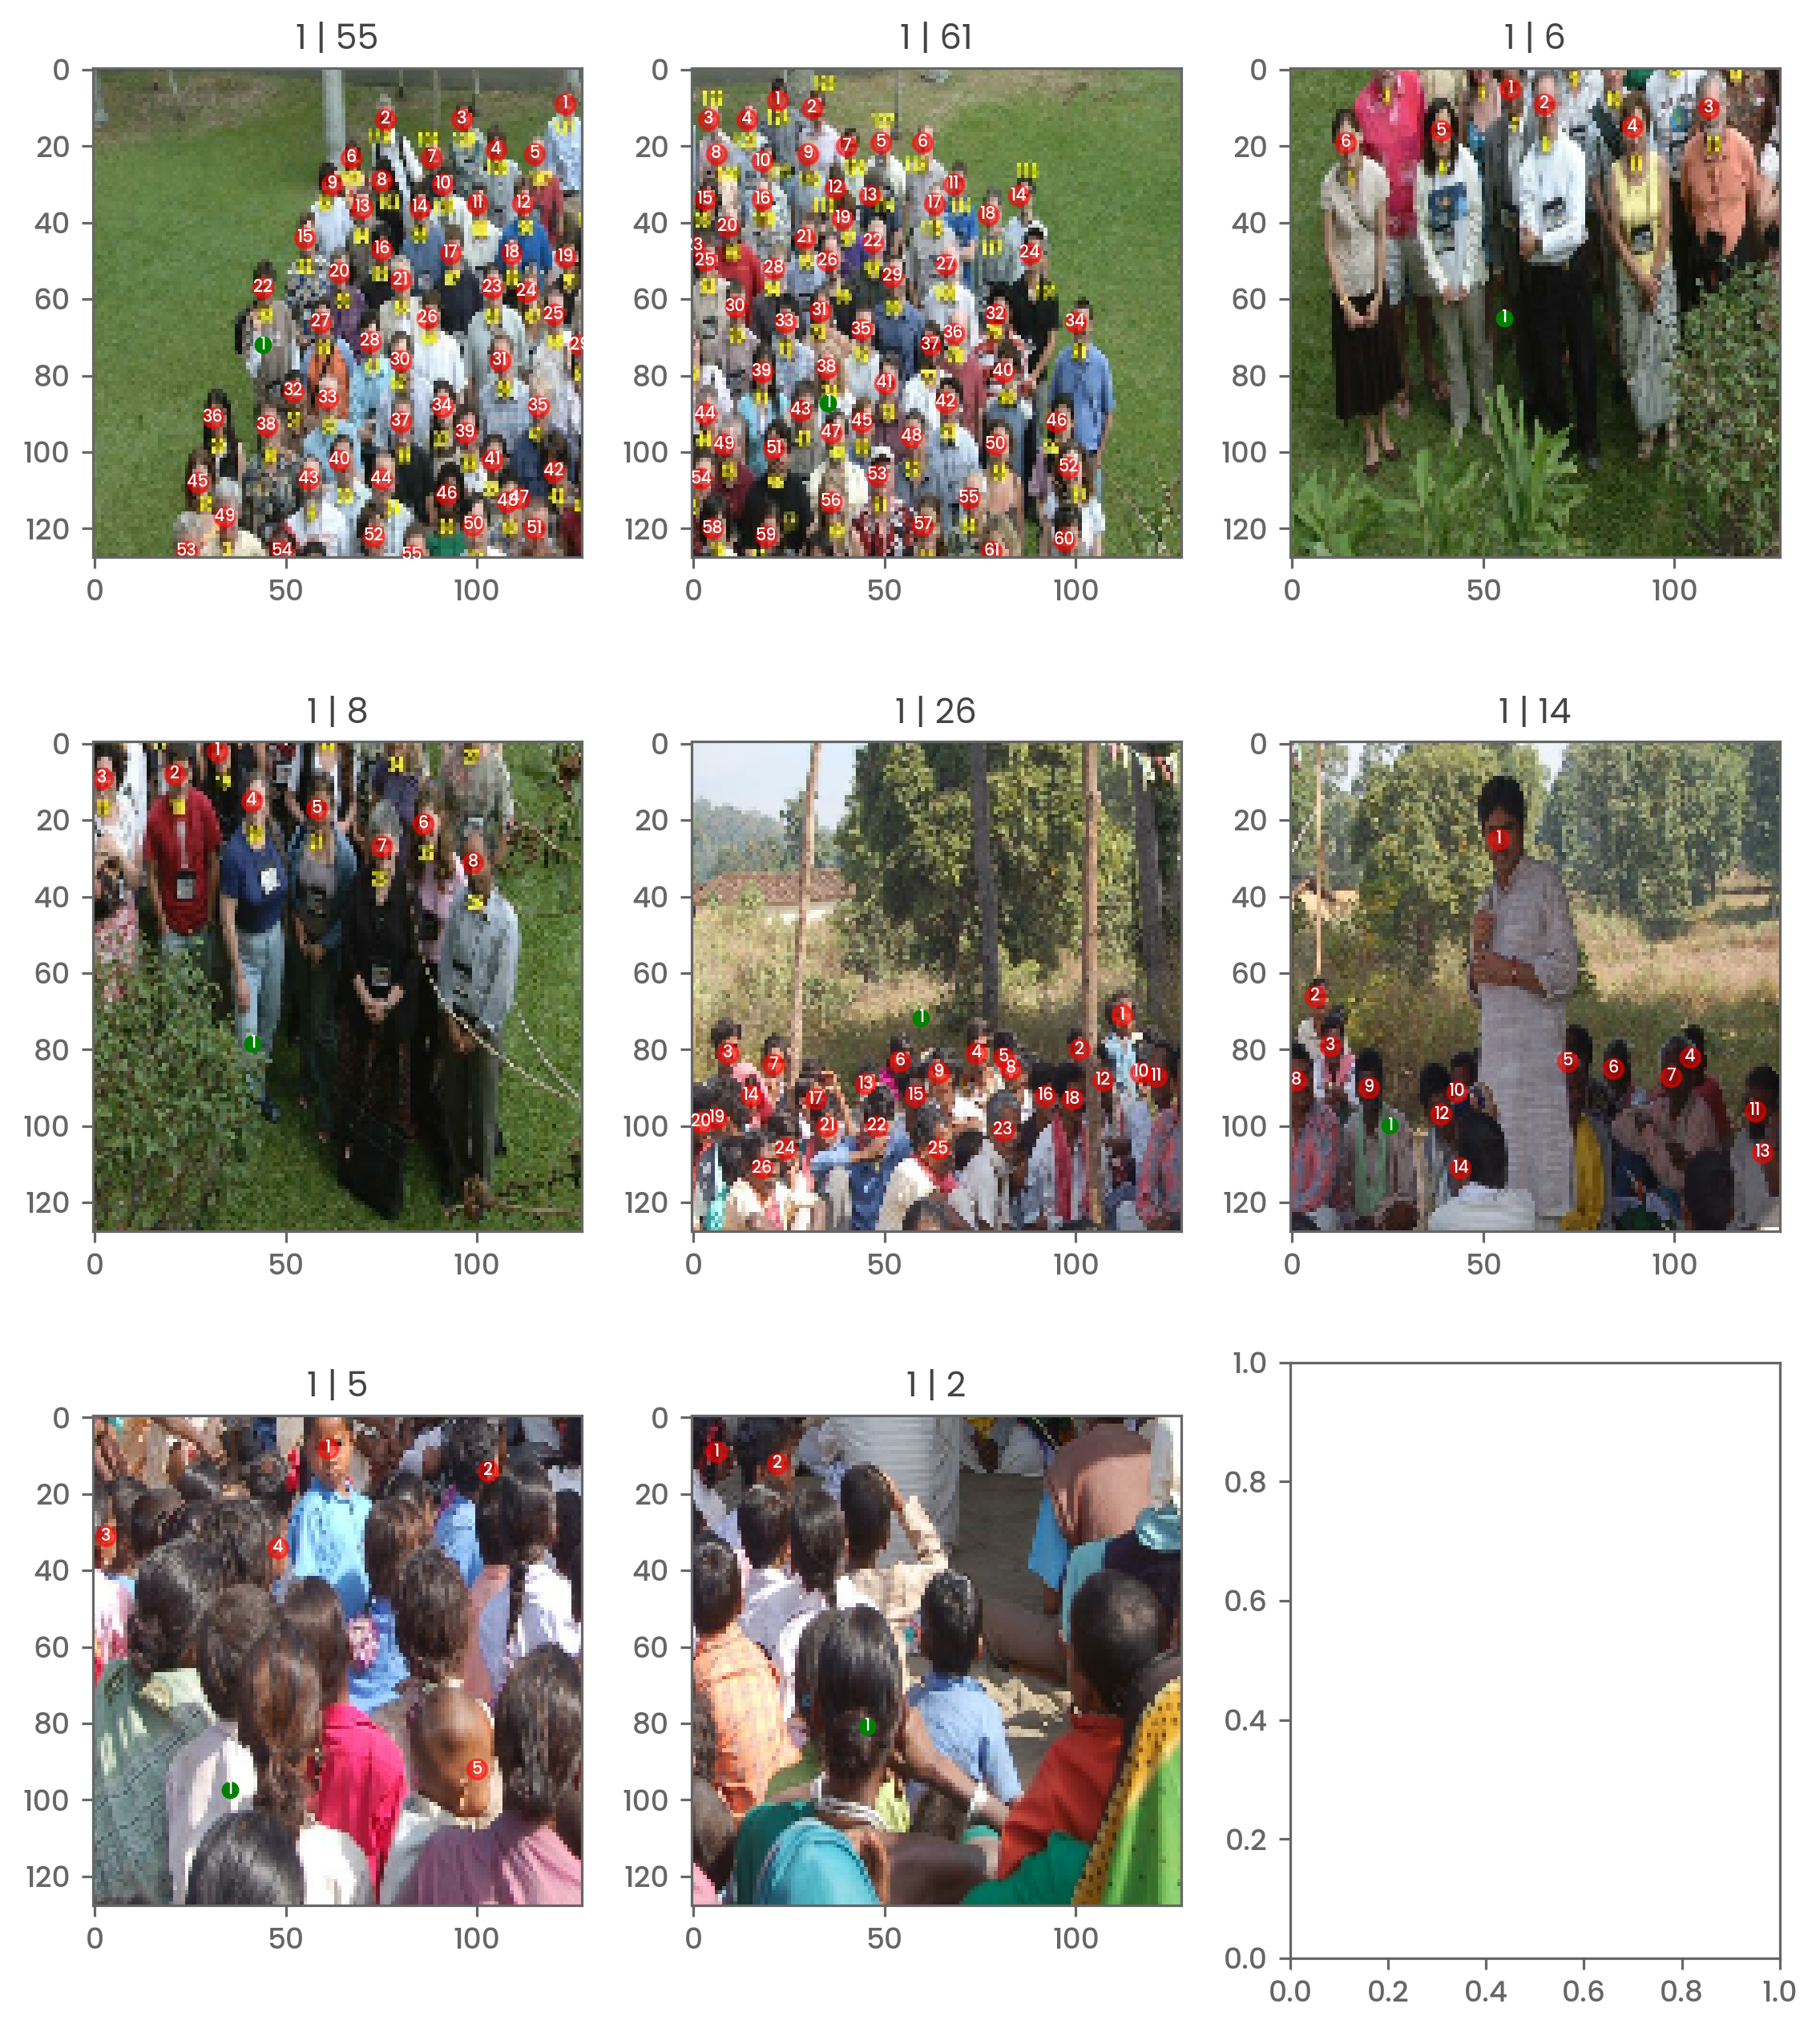

In [ ]:
itr = iter(train_prep_ds.batch(2).map(extract_patches))
# itr = iter(train_prep_ds.batch(2))
images, y_true = next(itr)
y_pred = model(images)

print('Images: {} Y_True: {}'.format(images.shape, y_true.shape))

# y_pred = tf.random.uniform((2, 20, 4))
# plot_examples(images, y_true, y_pred)
# plot_examples(images[0], y_true[0], None)
flat_images = tf.reshape(images, [-1, PATCH_SIZE, PATCH_SIZE, 3])
flat_true = tf.reshape(y_true, [-1, PATCH_SIZE, PATCH_SIZE, 2])
flat_pred = tf.reshape(y_pred, [-1, 1, 4])
plot_examples(flat_images, flat_true, flat_pred)

In [68]:
import time

start = time.time()

LOSS_EPSILON = 1/(IMG_SIZE*IMG_SIZE*IMG_SIZE*IMG_SIZE)

ZERO_FT = 0.
ZERO_INT = 0

def compute_item_yxhw_loss(true_boxes, pred_boxes):
    """
        It computes MAE loss for YX and HW values between true and predicted boxes.
        The losses are computed just for the valid boxes
        Arguments:
            true_boxes: A tensor of boxes with shape (IMG_SIZE, IMG_SIZE, 2)
            The last dimension contains heights and widths of the boxes.

            pred_boxes: A tensor of boxes with shape (N_BOXES, 4)
            The last dimension contains YXHW values.

        Returns:
            * YX Loss
            * HW Loss
            * Box Count
    """
    # Input Grid Size
    size = true_boxes.shape[0]
    max_boxes = pred_boxes.shape[0]

    # tf.print('true_boxes: ', true_boxes, true_boxes.shape)
    # tf.print('pred_boxes: ', pred_boxes, pred_boxes.shape)

    # Generate valid box indices. We consider the boxes with non-zero heights as valid boxes
    boxes_grid_mask = tf.cast(tf.math.not_equal(true_boxes[:, :, 0], 0.), tf.float32)
    boxes_grid_indices = tf.where(boxes_grid_mask)

    # Compute the number of valid boxes and a linear valid box mask.
    num_boxes = tf.shape(boxes_grid_indices)[0]

    # tf.print('boxes_grid_indices: ', boxes_grid_indices, boxes_grid_indices.shape)
    # tf.print('num_boxes: ', num_boxes)
    # tf.print('max_boxes: ', max_boxes)

    if num_boxes == 0:
        return ZERO_FT, ZERO_FT, ZERO_INT

    # Compute YX and HW for valid boxes
    yx_boxes = tf.cast(boxes_grid_indices/size, dtype=tf.float32)
    hw_boxes = tf.gather_nd(indices=boxes_grid_indices, params=true_boxes)

    # tf.print('yx_boxes: ', yx_boxes, tf.shape(yx_boxes))
    # tf.print('hw_boxes: ', hw_boxes, tf.shape(hw_boxes))

    # We'll compute YX and HW losses individually.
    # We split the pred_boxes into YX and HW.
    yx_pred, hw_pred = tf.split(pred_boxes, 2, axis=-1)

    # tf.print('yx_pred: ', yx_pred, tf.shape(yx_pred))
    # tf.print('hw_pred: ', hw_pred, tf.shape(hw_pred))

    # Compute HW loss
    # yx_loss = tf.math.square(yx_pred[:num_boxes] - yx_boxes)
    # hw_loss = tf.math.abs(tf.math.log((hw_pred[:num_boxes] + LOSS_EPSILON)/(hw_boxes + LOSS_EPSILON)))
    yx_loss = tf.math.square(yx_pred - yx_boxes[:max_boxes])
    hw_loss = tf.math.abs(tf.math.log((hw_pred + LOSS_EPSILON)/(hw_boxes[:max_boxes] + LOSS_EPSILON)))

    # tf.print('yx_loss: ', yx_loss, tf.shape(yx_loss))
    # tf.print('hw_loss: ', hw_loss, tf.shape(hw_loss))

    return tf.math.reduce_sum(yx_loss), tf.math.reduce_sum(hw_loss), num_boxes

def compute_patch_yxhw_loss(y_true, y_pred):
    yx_loss, hw_loss, num_boxes = 0., 0., 0
    y_true_shape = tf.shape(y_true)
    batch_size, num_patches = y_true_shape[0], y_true_shape[1]

    for item_id in range(batch_size):
        for patch_id in range(num_patches):
            # item_id = 0
            result  = compute_item_yxhw_loss(y_true[item_id, patch_id], y_pred[item_id, patch_id])
            item_yx_loss, item_hw_loss, item_num_boxes = result

            yx_loss += item_yx_loss
            hw_loss += item_hw_loss
            num_boxes += item_num_boxes

            # tf.print('item_hw_loss:{}: '.format(item_id), item_hw_loss)
            # tf.print('item_num_boxes:{}: '.format(item_id), item_num_boxes)

    # tf.print('num_boxes: ', num_boxes)
    # tf.print('yx_loss: ', yx_loss)
    # tf.print('hw_loss: ', hw_loss)
    
    yx_loss = tf.math.divide_no_nan(yx_loss, tf.cast(num_boxes, dtype=tf.float32))
    hw_loss = tf.math.divide_no_nan(hw_loss, tf.cast(num_boxes, dtype=tf.float32))

    # tf.print('loss: ', loss)

    return yx_loss, hw_loss


compute_patch_yxhw_loss.__name__ = 'loss'

items, box_count, size = 3, 100, 256

@tf.function
def make_random_grid_boxes_tfn(item_id):
    return make_random_grid_boxes(box_count, size)

images = tf.random.normal((items, size, size, 3))
y_true = tf.map_fn(make_random_grid_boxes_tfn, tf.range(items), fn_output_signature=tf.float32)

images, y_true = patch_map_fn(images, y_true)

# y_true = tf.expand_dims(y_true, axis=1)
y_pred = tf.random.uniform((items, 256, 1, 4))

yx_loss, hw_loss = compute_patch_yxhw_loss(y_true, y_pred)
print('y_true: {} y_pred: {}'.format(y_true.shape.as_list(), y_pred.shape.as_list()))
print('yx_loss: {:.5f} hw_loss: {:.5f}'.format(yx_loss.numpy(), hw_loss.numpy()))

end = time.time()

delta = end - start
print(f'Time Elapsed: {delta:.3f} seconds')

# items = 1, delta = 10
# items = 2, delta = 46
# items = 3, delta = 70

2023-05-24 11:45:17.352007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


y_true: [3, 256, 16, 16, 2] y_pred: [3, 256, 1, 4]
yx_loss: 0.26007 hw_loss: 1.75158
Time Elapsed: 70.503 seconds


In [122]:
import time

start = time.time()

LOSS_EPSILON = 1/(IMG_SIZE*IMG_SIZE*IMG_SIZE*IMG_SIZE)

ZERO_FT = 0.
ZERO_INT = 0

def compute_item_box_loss(true_boxes, pred_boxes, boxes_grid_indices):
    # Compute the number of valid boxes and max predicted boxes
    max_boxes = pred_boxes.shape[0]
    num_boxes = tf.shape(boxes_grid_indices)[0]

    # Compute YX and HW for valid boxes
    yx_boxes = tf.cast(boxes_grid_indices/size, dtype=tf.float32)
    hw_boxes = tf.gather_nd(indices=boxes_grid_indices, params=true_boxes)

    # tf.print(tf.shape(true_boxes), )

    # tf.print('yx_boxes: ', yx_boxes, tf.shape(yx_boxes))
    # tf.print('hw_boxes: ', hw_boxes, tf.shape(hw_boxes))

    # We'll compute YX and HW losses individually.
    # We split the pred_boxes into YX and HW.
    yx_pred, hw_pred = tf.split(pred_boxes, 2, axis=-1)

    # tf.print('yx_pred: ', yx_pred, tf.shape(yx_pred))
    # tf.print('hw_pred: ', hw_pred, tf.shape(hw_pred))

    # Compute HW loss
    # yx_loss = tf.math.square(yx_pred[:num_boxes] - yx_boxes)
    # hw_loss = tf.math.abs(tf.math.log((hw_pred[:num_boxes] + LOSS_EPSILON)/(hw_boxes + LOSS_EPSILON)))
    yx_loss = tf.math.square(yx_pred - yx_boxes[:max_boxes])
    hw_loss = tf.math.abs(tf.math.log((hw_pred + LOSS_EPSILON)/(hw_boxes[:max_boxes] + LOSS_EPSILON)))

    # tf.print('yx_loss: ', yx_loss, tf.shape(yx_loss))
    # tf.print('hw_loss: ', hw_loss, tf.shape(hw_loss))

    return tf.math.reduce_sum(yx_loss), tf.math.reduce_sum(hw_loss), num_boxes

def compute_item_non_box_loss():
    return ZERO_FT, ZERO_FT, ZERO_INT

def compute_item_yxhw_loss(true_boxes, pred_boxes):
    """
        It computes MAE loss for YX and HW values between true and predicted boxes.
        The losses are computed just for the valid boxes
        Arguments:
            true_boxes: A tensor of boxes with shape (IMG_SIZE, IMG_SIZE, 2)
            The last dimension contains heights and widths of the boxes.

            pred_boxes: A tensor of boxes with shape (N_BOXES, 4)
            The last dimension contains YXHW values.

        Returns:
            * YX Loss
            * HW Loss
            * Box Count
    """
    # Input Grid Size
    size = true_boxes.shape[0]

    # tf.print('true_boxes: ', true_boxes, true_boxes.shape)
    # tf.print('pred_boxes: ', pred_boxes, pred_boxes.shape)

    # Generate valid box indices. We consider the boxes with non-zero heights as valid boxes
    boxes_grid_mask = tf.cast(tf.math.not_equal(true_boxes[:, :, 0], 0.), tf.float32)
    boxes_grid_indices = tf.where(boxes_grid_mask)

    # Compute the number of valid boxes and a linear valid box mask.
    num_boxes = tf.shape(boxes_grid_indices)[0]

    # tf.print('boxes_grid_indices: ', boxes_grid_indices, boxes_grid_indices.shape)
    # tf.print('num_boxes: ', num_boxes)
    # tf.print('max_boxes: ', max_boxes)

    return tf.cond(num_boxes == 0, compute_item_non_box_loss, lambda: compute_item_box_loss(true_boxes, pred_boxes, boxes_grid_indices))
    # if num_boxes == 0:
    #     return ZERO_FT, ZERO_FT, ZERO_INT
   

def compute_item_yxhw_loss_map_fn(args):
    tf.print(args[0].shape, args[1].shape)
    result = compute_item_yxhw_loss(args[0], args[1])
    tf.print('result: ', result)
    return result

def compute_patch_yxhw_loss(y_true, y_pred):
    yx_loss, hw_loss, num_boxes = 0., 0., 0
    y_true_shape = tf.shape(y_true)
    batch_size, num_patches = y_true_shape[0], y_true_shape[1]

    # for item_id in range(batch_size):
    item_id = 0
    true_boxes, pred_boxes = y_true[item_id], y_pred[item_id]
    
    grid_size = true_boxes.shape[2]
    max_boxes = pred_boxes.shape[1]

    tf.print('grid_size: ', grid_size)
    tf.print('max_boxes: ', max_boxes)

    boxes_grid_mask = tf.cast(tf.math.not_equal(true_boxes[..., 0], 0.), tf.float32)
    tf.print('item_id: ', item_id, ' num_boxes: ', tf.reduce_sum(boxes_grid_mask))

    boxes_grid_indices = tf.where(boxes_grid_mask)
    tf.print('boxes_grid_indices: ', boxes_grid_indices, boxes_grid_indices.shape)

        # for patch_id in range(num_patches):
        #     # item_id = 0
        #     result  = compute_item_yxhw_loss(y_true[item_id, patch_id], y_pred[item_id, patch_id])
        #     item_yx_loss, item_hw_loss, item_num_boxes = result

        #     yx_loss += item_yx_loss
        #     hw_loss += item_hw_loss
        #     num_boxes += item_num_boxes

            # tf.print('item_hw_loss:{}: '.format(item_id), item_hw_loss)
            # tf.print('item_num_boxes:{}: '.format(item_id), item_num_boxes)

    # tf.print('num_boxes: ', num_boxes)
    # tf.print('yx_loss: ', yx_loss)
    # tf.print('hw_loss: ', hw_loss)
    
    # yx_loss = tf.math.divide_no_nan(yx_loss, tf.cast(num_boxes, dtype=tf.float32))
    # hw_loss = tf.math.divide_no_nan(hw_loss, tf.cast(num_boxes, dtype=tf.float32))

    # tf.print('loss: ', loss)

    # return yx_loss, hw_loss
    return 0., 0.


compute_patch_yxhw_loss.__name__ = 'loss'

items, box_count, size = 1, 100, 256

@tf.function
def make_random_grid_boxes_tfn(item_id):
    return make_random_grid_boxes(box_count, size)

# images = tf.random.normal((items, size, size, 3))
# y_true = tf.map_fn(make_random_grid_boxes_tfn, tf.range(items), fn_output_signature=tf.float32)

# images, y_true = patch_map_fn(images, y_true)

# # y_true = tf.expand_dims(y_true, axis=1)
# y_pred = tf.random.uniform((items, 256, 1, 4))

yx_loss, hw_loss = compute_patch_yxhw_loss(y_true, y_pred)
print('y_true: {} y_pred: {}'.format(y_true.shape.as_list(), y_pred.shape.as_list()))
print('yx_loss: {:.5f} hw_loss: {:.5f}'.format(yx_loss, hw_loss))

end = time.time()

delta = end - start
print(f'Time Elapsed: {delta:.3f} seconds')

grid_size:  16
max_boxes:  1
item_id:  0  num_boxes:  100
boxes_grid_indices:  [[0 3 14]
 [0 13 9]
 [1 1 7]
 ...
 [198 4 12]
 [198 14 13]
 [210 15 10]] TensorShape([100, 3])
y_true: [1, 256, 16, 16, 2] y_pred: [1, 256, 1, 4]
yx_loss: 0.00000 hw_loss: 0.00000
Time Elapsed: 0.019 seconds
